# Подключение библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Olymps/droneshub

/content/drive/MyDrive/Olymps/droneshub


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # клонирование репозитория YOLOv5
!pip install -U -r yolov5/requirements.txt  # загрузка библиотек, необходимых для YOLOv5

In [ ]:
!pip install albumentations==1.0.3

In [ ]:
!pip install roboflow

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import json
import torch
import shutil

from google.colab.patches import cv2_imshow
from tqdm import tqdm
from roboflow import Roboflow

In [ ]:
WIDTH, HEIGHT = 1920, 1280
path = '/content/drive/MyDrive/Olymps/droneshub/'

# Настройка YOLOv5

In [ ]:
from IPython.core.magic import register_line_cell_magic

# Функция для записи текста из ячейки jupyter в файл
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/drive/MyDrive/Olymps/droneshub/yolov5/data/hyp.scratch.yaml
lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
copy_paste: 0.0

In [ ]:
%%writetemplate /content/drive/MyDrive/Olymps/droneshub/yolov5/models/custom_yolov5s.yaml
# parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cd /content/drive/MyDrive/Olymps/droneshub/yolov5

/content/drive/MyDrive/Olymps/droneshub/yolov5


# Скачиваем датасет

In [ ]:
rf = Roboflow(api_key="CanOLqTz1swWuIXXWrLb")
project = rf.workspace("new-workspace-fvqqv").project("russian-car-plates")
dataset = project.version(3).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to russian-car-plates-3 in yolov5pytorch:: 100%|██████████| 1345/1345 [00:17<00:00, 78.37it/s]


# Запускаем обучение

In [ ]:
!python train.py --img 1280 --cfg custom_yolov5s.yaml --hyp hyp.scratch.yaml --batch 12  --epochs 100 --data russian-car-plates-3/data.yaml --weights yolov5s.pt --workers 4 --name plates_yolo

train: weights=yolov5s.pt, cfg=custom_yolov5s.yaml, data=russian-car-plates-3/data.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=12, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=4, project=runs/train, name=plates_yolo, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-295-gf8722b4 Python-3.7.13 torch-1.11.0+cu102 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hs

# Делаем предсказания

In [ ]:
!python detect.py --weights runs/train/plates_yolo3/weights/best.pt --img 1280 --conf 0.4 --source /content/drive/MyDrive/Olymps/droneshub/yolov5/russian-car-plates-3/valid/images/

detect: weights=['runs/train/plates_yolo3/weights/best.pt'], source=/content/drive/MyDrive/Olymps/droneshub/yolov5/russian-car-plates-3/valid/images/, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-295-gf8722b4 Python-3.7.13 torch-1.11.0+cu102 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients, 16.7 GFLOPs
image 1/34 /content/drive/MyDrive/Olymps/droneshub/yolov5/russian-car-plates-3/valid/images/---------------392-_png.rf.ab0b9ab9f106509d5e45dbec1ff04008.jpg: 736x1280 1 plate, Done. (0.026s)
image 2/34 /content/drive/MyDrive/Olymps/droneshub/yolov5/russian-car-plates-3/valid/imag

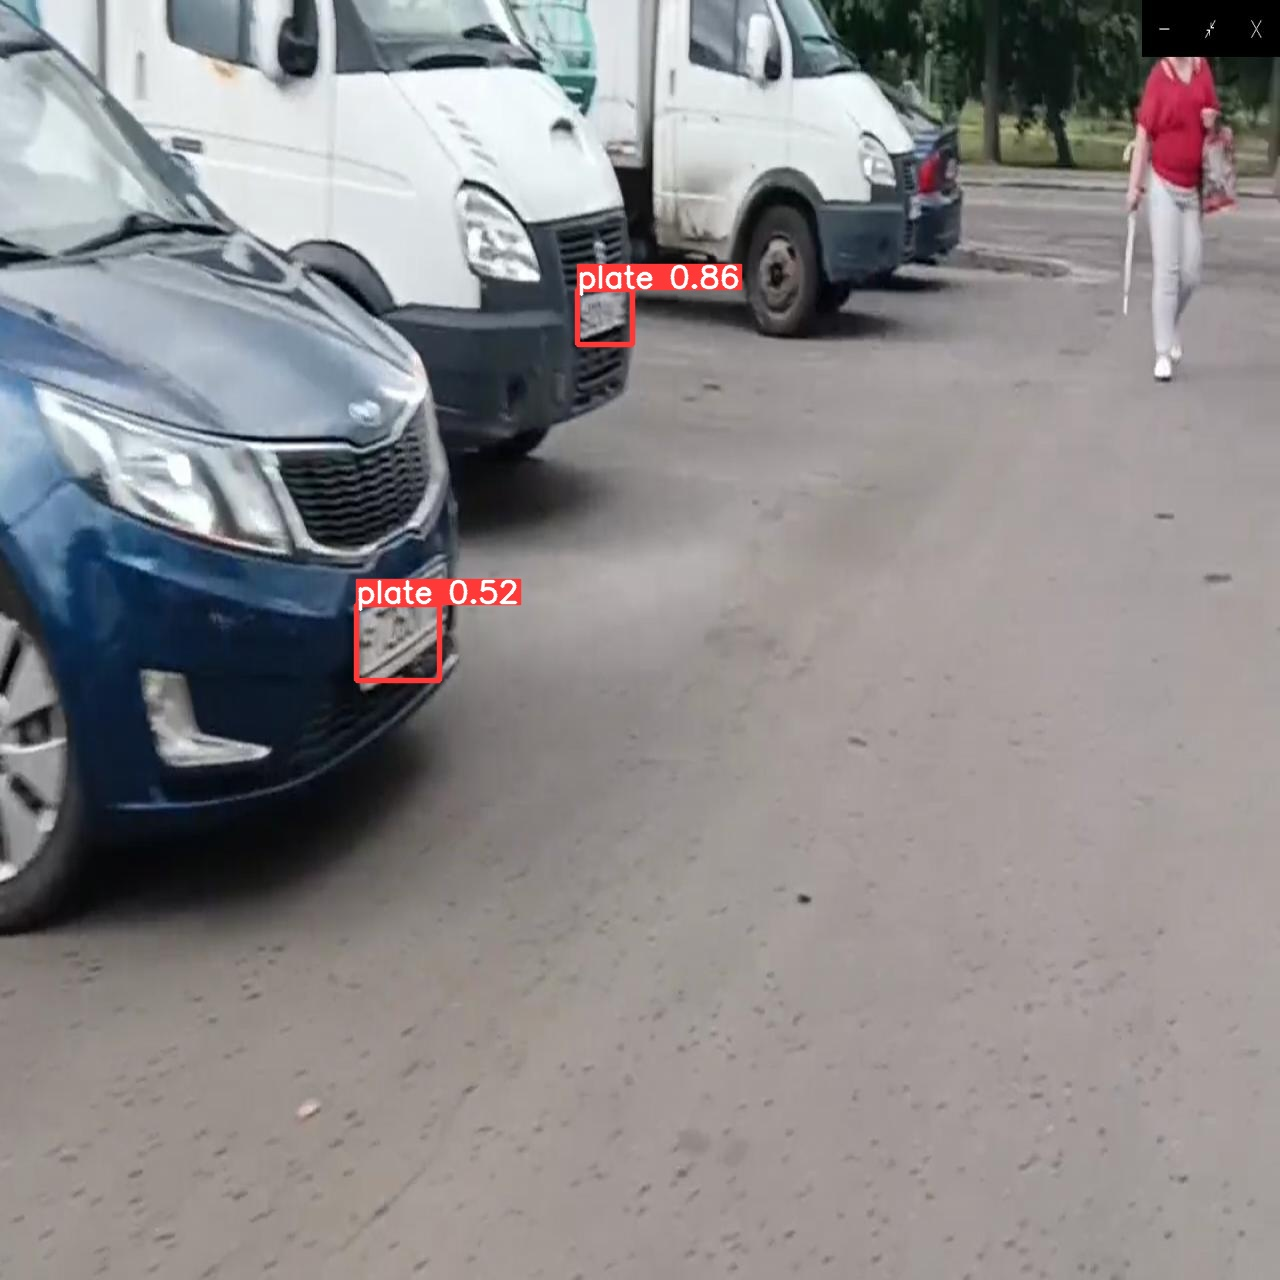

In [ ]:
cv2_imshow(cv2.imread('/content/drive/MyDrive/Olymps/droneshub/yolov5/runs/detect/exp7//---------------738-_png.rf.17d313b90bb4699d9c44f571c115a6ae.jpg'))

# Сохраняем веса

In [ ]:
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 8.1 MB/s 


In [ ]:
!python export.py --weights runs/train/plates_yolo3/weights/best.pt --include onnx

export: data=data/coco128.yaml, weights=['runs/train/plates_yolo3/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, train=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v6.1-295-gf8722b4 Python-3.7.13 torch-1.11.0+cu102 CPU

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients, 16.7 GFLOPs

PyTorch: starting from runs/train/plates_yolo3/weights/best.pt with output shape (1, 25200, 6) (14.5 MB)

ONNX: starting export with onnx 1.12.0...
ONNX: export success, saved as runs/train/plates_yolo3/weights/best.onnx (28.1 MB)

Export complete (4.15s)
Results saved to /content/drive/MyDrive/Olymps/droneshub/yolov5/runs/train/plates_yolo3/weights
Detect:          python detect.py --weights runs/train/plates_yolo3/weights/best.onnx 
Va

# Дополнительно: преобразование аннотаций в формат YOLO (если датасет не подготовлен)

In [ ]:
def xmllist_to_yolo(obj, cnt):
    filename = obj[0]
    img = cv2.imread(path_img2 + filename[:-3] + 'png')
    im_width, im_height = img.shape[1], img.shape[0]
    img = cv2.resize(img, (WIDTH, HEIGHT))
    try:
        items = []
        for crd in obj[1]:
            x, y, x2, y2 = crd[0], crd[1], crd[2], crd[3]
            x, y, x2, y2 = [i/im_width for i in crd[:2]], [i/im_height for i in crd[2:]]
            h, w, x_center, y_center = (y2 - y), (x2 - x), (x + x2)/2, (y + y2)/2
            label = 0 # только 1 класс 
            items.append(f'{label} {x_center:.{6}f} {y_center:.{6}f} {w:.{6}f} {h:.{6}f}')
        if cnt % 10 != 0:
            with open(f'/content/drive/MyDrive/Olymps/droneshub/dataset/labels/train/{filename[:-4]}.txt', 'w') as txt:
                txt.write('\n'.join(items))
            cv2.imwrite(f'/content/drive/MyDrive/Olymps/droneshub/dataset/images/train/{filename[:-4]}.jpg', img)
        else:
            with open(f'/content/drive/MyDrive/Olymps/droneshub/dataset/labels/valid/{filename[:-4]}.txt', 'w') as txt:
                txt.write('\n'.join(items))
            cv2.imwrite(f'/content/drive/MyDrive/Olymps/droneshub/dataset/images/valid/{filename[:-4]}.jpg', img)

    except IndexError:
        # print(row)
        print(filename)
  

def json_to_yolo(filename, cnt):
    img = cv2.imread(path_img + filename[:-3] + 'png')
    try:
        with open(path_ann + filename[:-4] + '.json', 'r') as jsn:
            jsn = json.load(jsn)
            shapes = jsn['shapes']
        items = []
        for sh in shapes:
            crd = sh['points']
            x, y, x2, y2 = crd[0][0], crd[0][1], crd[1][0], crd[1][1]
            x, y, x2, y2 = [i/im_width for i in crd[:2]], [i/im_height for i in crd[2:]]
            h, w, x_center, y_center = (y2 - y), (x2 - x), (x + x2)/2, (y + y2)/2
            label = 0  # только 1 класс 
            items.append(f'{label} {x_center:.{6}f} {y_center:.{6}f} {w:.{6}f} {h:.{6}f}')

        # for YOLOv5
        if cnt % 10 != 0:
            with open(f'{path}/dataset/labels/train/{filename[:-4]}.txt', 'w') as txt:
                txt.write('\n'.join(items))
            cv2.imwrite(f'{path}/dataset/images/train/{filename[:-4]}.jpg', img)
        else:
            with open(f'{path}/dataset/labels/valid/{filename[:-4]}.txt', 'w') as txt:
                txt.write('\n'.join(items))
            cv2.imwrite(f'{path}/dataset/images/valid/{filename[:-4]}.jpg', img)

        # for YOLOv4
        # if cnt % 10 != 0:
        #     with open(f'{path}train/{filename[:-4]}.txt', 'w') as txt:
        #         txt.write('\n'.join(items))
        #     cv2.imwrite(f'{path}train/{filename[:-4]}.jpg', img)
        # else:
        #     with open(f'{path}val/{filename[:-4]}.txt', 'w') as txt:
        #         txt.write('\n'.join(items))
        #     cv2.imwrite(f'{path}val/{filename[:-4]}.jpg', img)

    except IndexError:
        print(filename)